In [1]:
import pandas as pd
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
import KeyFunctions as me
import tensorflow as tf
RandState = 92

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

n = 4

In [2]:
from sklearn.model_selection import train_test_split

#Import Full Triclosan Dataset
df, labels = me.ConstructCombinedChlorDataset()
df = me.BaselineCorrection(me.BaselineCorrection(df))

[train, test] = train_test_split(df, random_state = RandState, shuffle = True, train_size = 0.9)

y_tn = train.index
y_tt = test.index
X_tt = test.to_numpy()
X_tn = train.to_numpy()

#Augment Data to 4000 Spectra
X_tnAu, y_tnAu = me.AugmentData(X_tn, y_tn, 4000, df.columns.to_numpy(), False)

In [3]:
#Set Training Parameters
verbose = 1
epochsvec = [5, 20, 50]
batch_sizevec = [10, 50, 100]
epochs = epochsvec[1]
batch_size = batch_sizevec[1]

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Scale X-Data with Training Xs
scaler = StandardScaler()
scaler.fit(X_tnAu)
X_tnS = scaler.transform(X_tnAu)
X_ttS = scaler.transform(X_tt)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))


#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnS.reshape(X_tnS.shape[0], X_tnS.shape[1], 1)
X_tt_p = X_ttS.reshape(X_ttS.shape[0], X_ttS.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)

display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

ytruth = tf.argmax(input = y_ttT, axis = 1).numpy()
ytruth = encoder.inverse_transform(ytruth)

TensorShape([4000, 618, 1])

TensorShape([4000, 5])

TensorShape([5, 618, 1])

TensorShape([5, 5])

In [5]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 3,verbose = 0, restore_best_weights = True)

#Fit Model
model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split = 0.1, callbacks = stopper)

#Evaluate Model
_, SCaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(SCaccuracy)

Epoch 1/20
72/72 [==============================] - 6s 62ms/step - loss: 0.1581 - accuracy: 0.9447 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 2/20
72/72 [==============================] - 5s 68ms/step - loss: 2.8650e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 3/20
72/72 [==============================] - 4s 56ms/step - loss: 1.4340e-04 - accuracy: 1.0000 - val_loss: 9.5949e-04 - val_accuracy: 1.0000
Epoch 4/20
72/72 [==============================] - 4s 56ms/step - loss: 8.1203e-05 - accuracy: 1.0000 - val_loss: 7.1804e-04 - val_accuracy: 1.0000
Epoch 5/20
72/72 [==============================] - 5s 66ms/step - loss: 5.7122e-05 - accuracy: 1.0000 - val_loss: 5.6125e-04 - val_accuracy: 1.0000
Epoch 6/20
72/72 [==============================] - 5s 67ms/step - loss: 4.0062e-05 - accuracy: 1.0000 - val_loss: 4.6528e-04 - val_accuracy: 1.0000
Epoch 7/20
72/72 [==============================] - 4s 60ms/step - loss: 2.9465e-05 - accuracy: 1.0000 - val_loss: 3.8

0.800000011920929

In [6]:
#Make Prediction
SCypred = model.predict(X_ttT)
SCypred = tf.argmax(input = SCypred, axis = 1).numpy()
SCypred = encoder.inverse_transform(SCypred)


In [7]:
#Extract Convolution Feature Maps
convlayer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)

spectra = X_ttT[n, :, 0]
specvec = list()
specvec.append(spectra)
spectra = tf.reshape(spectra, (1, len(spectra), 1))

SCfeature_maps = convlayer.predict(spectra)
display(SCfeature_maps)

array([[[0.04535324, 0.10738379, 0.        , ..., 0.        ,
         0.        , 0.04164099],
        [0.        , 0.06302233, 0.        , ..., 0.10980735,
         0.11215509, 0.16741125],
        [0.        , 0.02742722, 0.        , ..., 0.07651592,
         0.07110766, 0.10858439],
        ...,
        [0.        , 0.1118104 , 0.        , ..., 0.07046501,
         0.03110789, 0.16464676],
        [0.        , 0.13199466, 0.        , ..., 0.03952168,
         0.        , 0.1516746 ],
        [0.        , 0.05618959, 0.        , ..., 0.10244957,
         0.13996758, 0.16395509]]], dtype=float32)

In [8]:
scaler = StandardScaler()
scaler.fit(X_tnAu)
X_tnS= scaler.transform(X_tnAu)
X_ttS = scaler.transform(X_tt)

#Apply Fourier Transform to Training and Testing Data
X_tnf = np.apply_along_axis(np.fft.fft, axis=1, arr=X_tnS)
X_ttf = np.apply_along_axis(np.fft.fft, axis=1, arr=X_ttS)

#Combine Real and Imaginary Part of FT in form [real, imaginary]
X_tnf = np.append(X_tnf.real, X_tnf.imag, axis = 1)
X_ttf = np.append(X_ttf.real, X_ttf.imag, axis = 1)
X_tnf= X_tnf.astype('float32')
X_ttf= X_ttf.astype('float32')

#Scale X-Data with Training Xs
#scaler = StandardScaler()
#scaler.fit(X_tnf)
#X_tnf = scaler.transform(X_tnf)
#X_ttf = scaler.transform(X_ttf)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))

#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnf.reshape(X_tnf.shape[0], X_tnf.shape[1], 1)
X_tt_p = X_ttf.reshape(X_ttf.shape[0], X_ttf.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)


display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

TensorShape([4000, 1236, 1])

TensorShape([4000, 5])

TensorShape([5, 1236, 1])

TensorShape([5, 5])

In [9]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 3,verbose = 0, restore_best_weights = True)

#Fit Model
model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose,  validation_split=0.1, callbacks = stopper)

#Evaluate Model
_, FTaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(FTaccuracy)

Epoch 1/20
72/72 [==============================] - 10s 130ms/step - loss: 1.3985 - accuracy: 0.9039 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 2/20
72/72 [==============================] - 10s 135ms/step - loss: 0.0083 - accuracy: 0.9958 - val_loss: 2.7968e-04 - val_accuracy: 1.0000
Epoch 3/20
72/72 [==============================] - 10s 141ms/step - loss: 1.5332e-04 - accuracy: 1.0000 - val_loss: 1.0262e-04 - val_accuracy: 1.0000
Epoch 4/20
72/72 [==============================] - 9s 120ms/step - loss: 6.9919e-05 - accuracy: 1.0000 - val_loss: 5.8085e-05 - val_accuracy: 1.0000
Epoch 5/20
72/72 [==============================] - 10s 135ms/step - loss: 4.3436e-05 - accuracy: 1.0000 - val_loss: 3.8193e-05 - val_accuracy: 1.0000
Epoch 6/20
72/72 [==============================] - 9s 131ms/step - loss: 3.0037e-05 - accuracy: 1.0000 - val_loss: 2.7831e-05 - val_accuracy: 1.0000
Epoch 7/20
72/72 [==============================] - 12s 163ms/step - loss: 2.3916e-05 - accuracy: 1.0000 - v

0.6000000238418579

In [10]:
#Make Prediction
FTypred = model.predict(X_ttT)
FTypred = tf.argmax(input = FTypred, axis = 1).numpy()
FTypred = encoder.inverse_transform(FTypred)

In [11]:
convlayer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)
convlayer.summary()

spectra = X_ttT[n, :, 0]
specvec.append(spectra)
spectra = tf.reshape(spectra, (1, len(spectra), 1))

FTfeature_maps = convlayer.predict(spectra)
display(FTfeature_maps)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2_input (InputLayer)  [(None, 1236, 1)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1234, 64)          256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


array([[[18.062044  , 19.12939   ,  0.        , ..., 25.445692  ,
         40.46593   ,  0.        ],
        [ 6.2783422 ,  1.8490666 ,  6.6296897 , ...,  0.93620765,
          8.068607  ,  0.        ],
        [ 0.06889538,  0.        ,  4.2524757 , ...,  0.        ,
          0.        ,  0.31356278],
        ...,
        [ 1.8941686 ,  2.978131  ,  3.1309426 , ...,  1.8395094 ,
          3.8650048 ,  1.7599766 ],
        [ 1.295627  ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  5.718983  ,  0.        , ...,  3.012161  ,
          0.        , 12.433524  ]]], dtype=float32)

In [12]:
#Apply Welsh-Hadamard Transform to Training and Testing Data
from sympy.discrete.transforms import fwht, ifwht

#scaler = StandardScaler()
#scaler.fit(X_tnAu)
#X_tnAu = scaler.transform(X_tnAu)
#X_tt = scaler.transform(X_tt)

X_tnh = np.apply_along_axis(fwht, axis=1, arr=X_tnAu)
X_tth = np.apply_along_axis(fwht, axis=1, arr=X_tt)
X_tnh = X_tnh.astype('float32')
X_tth = X_tth.astype('float32')

#Scale X-Data with Training Xs
scaler = StandardScaler()
scaler.fit(X_tnh)
X_tnh = scaler.transform(X_tnh)
X_tth = scaler.transform(X_tth)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))

#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnh.reshape(X_tnh.shape[0], X_tnh.shape[1], 1)
X_tt_p = X_tth.reshape(X_tth.shape[0], X_tth.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)


display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

TensorShape([4000, 1024, 1])

TensorShape([4000, 5])

TensorShape([5, 1024, 1])

TensorShape([5, 5])

In [13]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = 'min',\
                                           patience = 3, verbose = 1, restore_best_weights = True)

#Fit Model
model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose,  validation_split=0.1, callbacks = stopper)

#Evaluate Model
_, HTaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(HTaccuracy)

Epoch 1/20
72/72 [==============================] - 8s 99ms/step - loss: 0.3173 - accuracy: 0.9056 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 2/20
72/72 [==============================] - 9s 123ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/20
72/72 [==============================] - 10s 133ms/step - loss: 4.6982e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 4/20
72/72 [==============================] - 9s 127ms/step - loss: 2.8518e-04 - accuracy: 1.0000 - val_loss: 7.5635e-04 - val_accuracy: 1.0000
Epoch 5/20
72/72 [==============================] - 8s 112ms/step - loss: 1.9194e-04 - accuracy: 1.0000 - val_loss: 5.3080e-04 - val_accuracy: 1.0000
Epoch 6/20
72/72 [==============================] - 9s 120ms/step - loss: 1.2115e-04 - accuracy: 1.0000 - val_loss: 3.7438e-04 - val_accuracy: 1.0000
Epoch 7/20
72/72 [==============================] - 10s 146ms/step - loss: 1.0013e-04 - accuracy: 1.0000 - val_loss: 2.8

0.800000011920929

In [14]:
#Make Prediction
HTypred = model.predict(X_ttT)
HTypred = tf.argmax(input = HTypred, axis = 1).numpy()
HTypred = encoder.inverse_transform(HTypred)

In [15]:
convlayer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)
convlayer.summary()

spectra = X_ttT[n, :, 0]
specvec.append(spectra)
spectra = tf.reshape(spectra, (1, len(spectra), 1))

HTfeature_maps = convlayer.predict(spectra)
display(HTfeature_maps)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4_input (InputLayer)  [(None, 1024, 1)]         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1022, 64)          256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


array([[[0.19858278, 0.04382637, 0.        , ..., 0.        ,
         0.05381447, 0.24481274],
        [0.        , 0.        , 0.10045599, ..., 0.05026924,
         0.20242327, 0.05751674],
        [0.        , 0.03427495, 0.03609918, ..., 0.05966894,
         0.        , 0.0084716 ],
        ...,
        [0.06372076, 0.        , 0.        , ..., 0.        ,
         0.03719138, 0.        ],
        [0.13987786, 0.11960557, 0.        , ..., 0.        ,
         0.        , 0.02868954],
        [0.11734384, 0.        , 0.00166809, ..., 0.        ,
         0.09316382, 0.13301285]]], dtype=float32)

In [16]:
from sklearn.metrics import confusion_matrix
display(SCypred)
CMSC = confusion_matrix(ytruth, SCypred, labels = labels)
CMFT = confusion_matrix(ytruth, FTypred, labels = labels)
CMHT = confusion_matrix(ytruth, HTypred, labels = labels)
display(SCaccuracy, FTaccuracy, HTaccuracy)

array(['10-3', '10-7', '10-7', '10-3', '10-6'], dtype=object)

0.800000011920929

0.6000000238418579

0.800000011920929

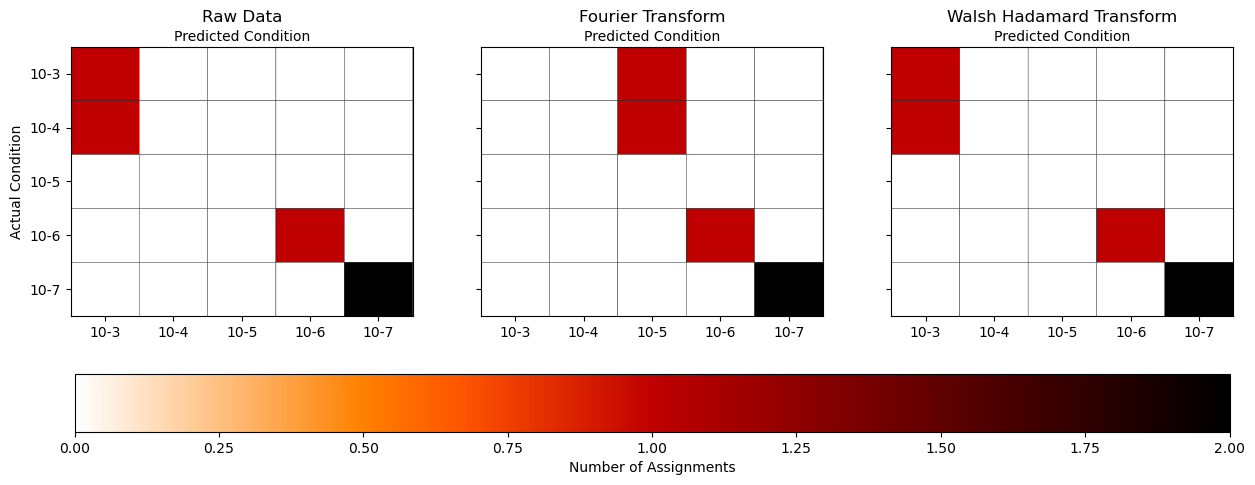

In [17]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = [15, 5])

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

pcm = axs[0].pcolor(CMSC, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[0].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_yticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_ylabel("Actual Condition")
axs[0].set_xlabel("Predicted Condition")
axs[0].xaxis.set_label_position('top') 
axs[0].set_title('Raw Data');

axs[1].pcolor(CMFT, edgecolors = 'k', cmap = 'gist_heat_r');
plt.gca().invert_yaxis()
axs[1].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[1].set_title('Fourier Transform');
axs[1].set_xlabel("Predicted Condition")
axs[1].xaxis.set_label_position('top')

axs[2].pcolor(CMHT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[2].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels);
axs[2].set_title('Walsh Hadamard Transform');
axs[2].set_xlabel("Predicted Condition")
axs[2].xaxis.set_label_position('top')

fig.colorbar(pcm, ax = axs[:], location = 'bottom', label = 'Number of Assignments');